In [244]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE



def run_training_loop(X_train, y_train, X_test, y_test, task="a", class_weight: str = 'balanced', verbose: bool = False,  average='micro'):
    
    
    # Define classifiers
    classifiers = {
    "Logistic Regression": LogisticRegression(class_weight=class_weight),
    "Decision Tree": DecisionTreeClassifier(class_weight=class_weight),
    "Random Forest": RandomForestClassifier(class_weight=class_weight),
    "Support Vector Machine": SVC(class_weight=class_weight, probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "K-Nearest Neighbors Rigid": KNeighborsClassifier(n_neighbors=50)
    }

    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=10, shuffle=True)

    # Metrics storage
    results = {name: {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []} for name in classifiers.keys()}
    n_classes = len(np.unique(y_test))  
    
    aggregate_conf_matrix_train = {name: np.zeros((n_classes, n_classes)) for name in classifiers.keys()}
    aggregate_conf_matrix_test = {name: np.zeros((n_classes, n_classes)) for name in classifiers.keys()}
    


    for train_index, val_index in skf.split(X_train, y_train):
        X_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # Standardize features
        scaler = StandardScaler()
        X_cv = scaler.fit_transform(X_cv)
        X_val = scaler.transform(X_val)

        for name, clf in classifiers.items():
            # Train the classifier
            clf.fit(X_cv, y_cv)
            
            # Predict
            y_pred = clf.predict(X_val)
            
            # Calculate metrics
            acc = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred, average=average)
            recall = recall_score(y_val, y_pred, average=average)
            f1 = f1_score(y_val, y_pred, average=average)
            
            conf_matrix = confusion_matrix(y_val, y_pred, labels=np.unique(y_test))
            aggregate_conf_matrix_train[name] += conf_matrix
            
            
            
            # Store metrics
            results[name]['accuracy'].append(acc)
            results[name]['precision'].append(precision)
            results[name]['recall'].append(recall)
            results[name]['f1_score'].append(f1)

        if verbose:
            # Display results
            for name, metrics in results.items():
                print(f"Classifier: {name}")
                print(f"  Accuracy:  {np.mean(metrics['accuracy']):.4f} ± {np.std(metrics['accuracy']):.4f}")
                print(f"  Precision: {np.mean(metrics['precision']):.4f} ± {np.std(metrics['precision']):.4f}")
                print(f"  Recall:    {np.mean(metrics['recall']):.4f} ± {np.std(metrics['recall']):.4f}")
                # print(f"  F1 Score:  {np.mean(metrics['f1_score']):.4f} ± {np.std(metrics['f1_score']):.4f}")
                print()

            # Detailed classification report for each classifier on the last fold
            for name, clf in classifiers.items():
                y_pred = clf.predict(X_test)
                print(f"Classifier: {name}")
                print(classification_report(y_cv, y_pred))
                print()
                
    results_test = {name: {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []} for name in classifiers.keys()}
    for name, clf in classifiers.items():
        # Train the classifier on the full training set
        clf.fit(X_train, y_train)
        
        # Predict
        y_pred = clf.predict(X_test)
        
        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=average)
        recall = recall_score(y_test, y_pred, average=average)
        f1 = f1_score(y_test, y_pred, average=average)
        
        conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
        aggregate_conf_matrix_test[name] += conf_matrix
        
        # Store metrics
        results_test[name]['accuracy'].append(acc)
        results_test[name]['precision'].append(precision)
        results_test[name]['recall'].append(recall)
        results_test[name]['f1_score'].append(f1)
    
    

    return results, results_test, aggregate_conf_matrix_train, aggregate_conf_matrix_test

In [281]:
def print_pca_variance(X_train, n_components=2):
    pca = PCA(n_components=n_components)

    X_train = StandardScaler().fit_transform(X_train)
    X_train = pca.fit_transform(X_train)
    print(pca.explained_variance_ratio_)
    print("Sum of the two PCS", pca.explained_variance_ratio_.sum())
    
def get_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

def standard_scale(data):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return pd.DataFrame(data_scaled, columns=data.columns, index=data.index)





def plot_boxplots(results, y):
    accuracy_data = []
    precision_data = []
    recall_data = []
    f1_data = []
    
    class_names = sorted(set(y))

    for model, metrics in results.items():
        # Accuracy
        for acc in metrics["accuracy"]:
            accuracy_data.append([model, acc])

        # Precision and Recall for each class
        for fold in range(len(metrics["precision"])):
            for class_idx, prec in enumerate(metrics["precision"][fold]):
                precision_data.append([model, class_names[class_idx], prec])
            for class_idx, rec in enumerate(metrics["recall"][fold]):
                recall_data.append([model, class_names[class_idx], rec])
            for class_idx, f1 in enumerate(metrics["f1_score"][fold]):
                f1_data.append([model, class_names[class_idx], f1])

    # Convert to DataFrame for easier plotting
    accuracy_df = pd.DataFrame(accuracy_data, columns=["Model", "Accuracy"])
    precision_df = pd.DataFrame(precision_data, columns=["Model", "Class", "Precision"])
    recall_df = pd.DataFrame(recall_data, columns=["Model", "Class", "Recall"])
    f1_df = pd.DataFrame(f1_data, columns=["Model", "Class", "F1 Score"])

   
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    # Boxplot for Accuracy
    sns.boxplot(x="Model", y="Accuracy", data=accuracy_df, ax=axs[0, 0])
    axs[0, 0].set_title('Accuracy Comparison')
    axs[0, 0].set_ylim(0, 1)
    labels = axs[0, 0].get_xticklabels()
    plt.setp(labels, rotation=45)

    # Boxplot for Precision
    sns.boxplot(x="Model", y="Precision", hue="Class", data=precision_df, ax=axs[0, 1])
    axs[0, 1].set_title('Precision Comparison by Class')
    axs[0, 1].set_ylim(0, 1)
    labels = axs[0, 1].get_xticklabels()
    plt.setp(labels, rotation=45)
    axs[0, 1].legend(title='Class', bbox_to_anchor=(1.04, 0.5), loc="center left")

    # Boxplot for Recall
    sns.boxplot(x="Model", y="Recall", hue="Class", data=recall_df, ax=axs[1, 0])
    axs[1, 0].set_title('Recall Comparison by Class')
    axs[1, 0].set_ylim(0, 1)
    labels = axs[1, 0].get_xticklabels()
    plt.setp(labels, rotation=45)
    axs[1, 0].legend(title='Class', bbox_to_anchor=(1.04, 0.5), loc="center left")

    # Boxplot for F1 Score
    sns.boxplot(x="Model", y="F1 Score", hue="Class", data=f1_df, ax=axs[1, 1])
    axs[1, 1].set_title('F1 Score Comparison by Class')
    axs[1, 1].set_ylim(0, 1)
    labels = axs[1, 1].get_xticklabels()
    plt.setp(labels, rotation=45)
    axs[1, 1].legend(title='Class', bbox_to_anchor=(1.04, 0.5), loc="center left")

    plt.tight_layout()
    plt.show()
    
    
def plot_confusion_matricies(aggregate_conf_matrix_train: dict, aggregate_conf_matrix_test: dict, y):
    class_names = sorted(set(y))

    # Create a figure for train confusion matrices
    fig_train, axs_train = plt.subplots(3, 2, figsize=(15, 15))

    for i, (model, conf_matrix) in enumerate(aggregate_conf_matrix_train.items()):
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axs_train[i//2, i%2])
        axs_train[i//2, i%2].set_title(f"Train Confusion Matrix - {model}")
        axs_train[i//2, i%2].set_xlabel('Predicted')
        axs_train[i//2, i%2].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Create a figure for test confusion matrices
    fig_test, axs_test = plt.subplots(3, 2, figsize=(15, 15))

    for i, (model, conf_matrix) in enumerate(aggregate_conf_matrix_test.items()):
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axs_test[i//2, i%2])
        axs_test[i//2, i%2].set_title(f"Test Confusion Matrix - {model}")
        axs_test[i//2, i%2].set_xlabel('Predicted')
        axs_test[i//2, i%2].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()
    



def merge_dictionaries(dict1, dict2):

    merged_dict = {}
    # Iterate through each key in dict1
    for key in dict1.keys():
        if key in dict2:
            merged_dict[key] = {}
            for subkey in dict1[key]:
                # Check if the subkey exists in both dictionaries
                if subkey in dict2[key]:
                    # For accuracy, just append the list
                    if subkey == 'accuracy':
                        merged_dict[key][subkey] = dict1[key][subkey] + dict2[key][subkey]
                    else:
                        # For arrays, append the lists of arrays
                        merged_dict[key][subkey] = dict1[key][subkey] + dict2[key][subkey]
                else:
                    # Handle the case where a subkey exists in dict1 but not in dict2
                    merged_dict[key][subkey] = dict1[key][subkey]
        else:
            # Handle the case where a key exists in dict1 but not in dict2
            merged_dict[key] = dict1[key]
    # Add any keys from dict2 that are not in dict1
    for key in dict2.keys():
        if key not in dict1:
            merged_dict[key] = dict2[key]
    return merged_dict


def run_train_multiple_testing(X, y, task="a", class_weight: str = 'balanced', verbose: bool = False,  average='micro', do_smote=False):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    if do_smote:
        smote = SMOTE()
        X_train, y_train = smote.fit_resample(X_train, y_train)
    results, results_test, aggregated_conf_matrix_train, aggregated_conf_matrix_test  = run_training_loop(X_train, y_train, X_test, y_test, task=task, class_weight=class_weight, verbose=verbose, average=average)
    return results, results_test, aggregated_conf_matrix_train, aggregated_conf_matrix_test
    # results, results_test = run_training_loop(X_train, y_train, X_test, y_test, task=task, class_weight=class_weight, verbose=verbose, average=average)
    # return results, results_test


In [271]:

data = pd.read_csv("data/Fish3.txt", delimiter=" ")

X = data.drop(columns=['Species'])
y = data['Species']

scaled_data = standard_scale(X)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print_pca_variance(X, n_components=2)
get_distribution(y)

[0.64621014 0.255495  ]
Sum of the two PCS 0.901705137431857


{'Bream': 542,
 'Perch': 374,
 'Pike': 236,
 'Roach': 212,
 'SilverBream': 242,
 'Smelt': 219,
 'Whitewish': 41}

In [ ]:
all_results_train = []
all_results_test = []
all_conf_matrix_train = {}
all_conf_matrix_test = {}
for _ in range(50):
    results_train_temp, results_test_temp, conf_train, conf_test = run_train_multiple_testing(X, y, task="a", class_weight="balanced", average=None)
    all_results_train.append(results_train_temp)
    all_results_test.append(results_test_temp)
    for key, value in conf_train.items():
        if key in all_conf_matrix_train:
            all_conf_matrix_train[key] += value
        else:
            all_conf_matrix_train[key] = value
            
    for key, value in conf_test.items():
        if key in all_conf_matrix_test:
            all_conf_matrix_test[key] += value
        else:
            all_conf_matrix_test[key] = value
    

results_train = all_results_train[0]
results_test = all_results_test[0]

for i in range(1, len(all_results_train)):
    results_train = merge_dictionaries(results_train, all_results_train[i])
    results_test = merge_dictionaries(results_test, all_results_test[i])

for key, value in all_conf_matrix_train.items():
    all_conf_matrix_train[key] = value / value.sum(axis=1)[:, np.newaxis]
    
for key, value in all_conf_matrix_test.items():
    all_conf_matrix_test[key] = value / value.sum(axis=1)[:, np.newaxis]


print("successfully merged")


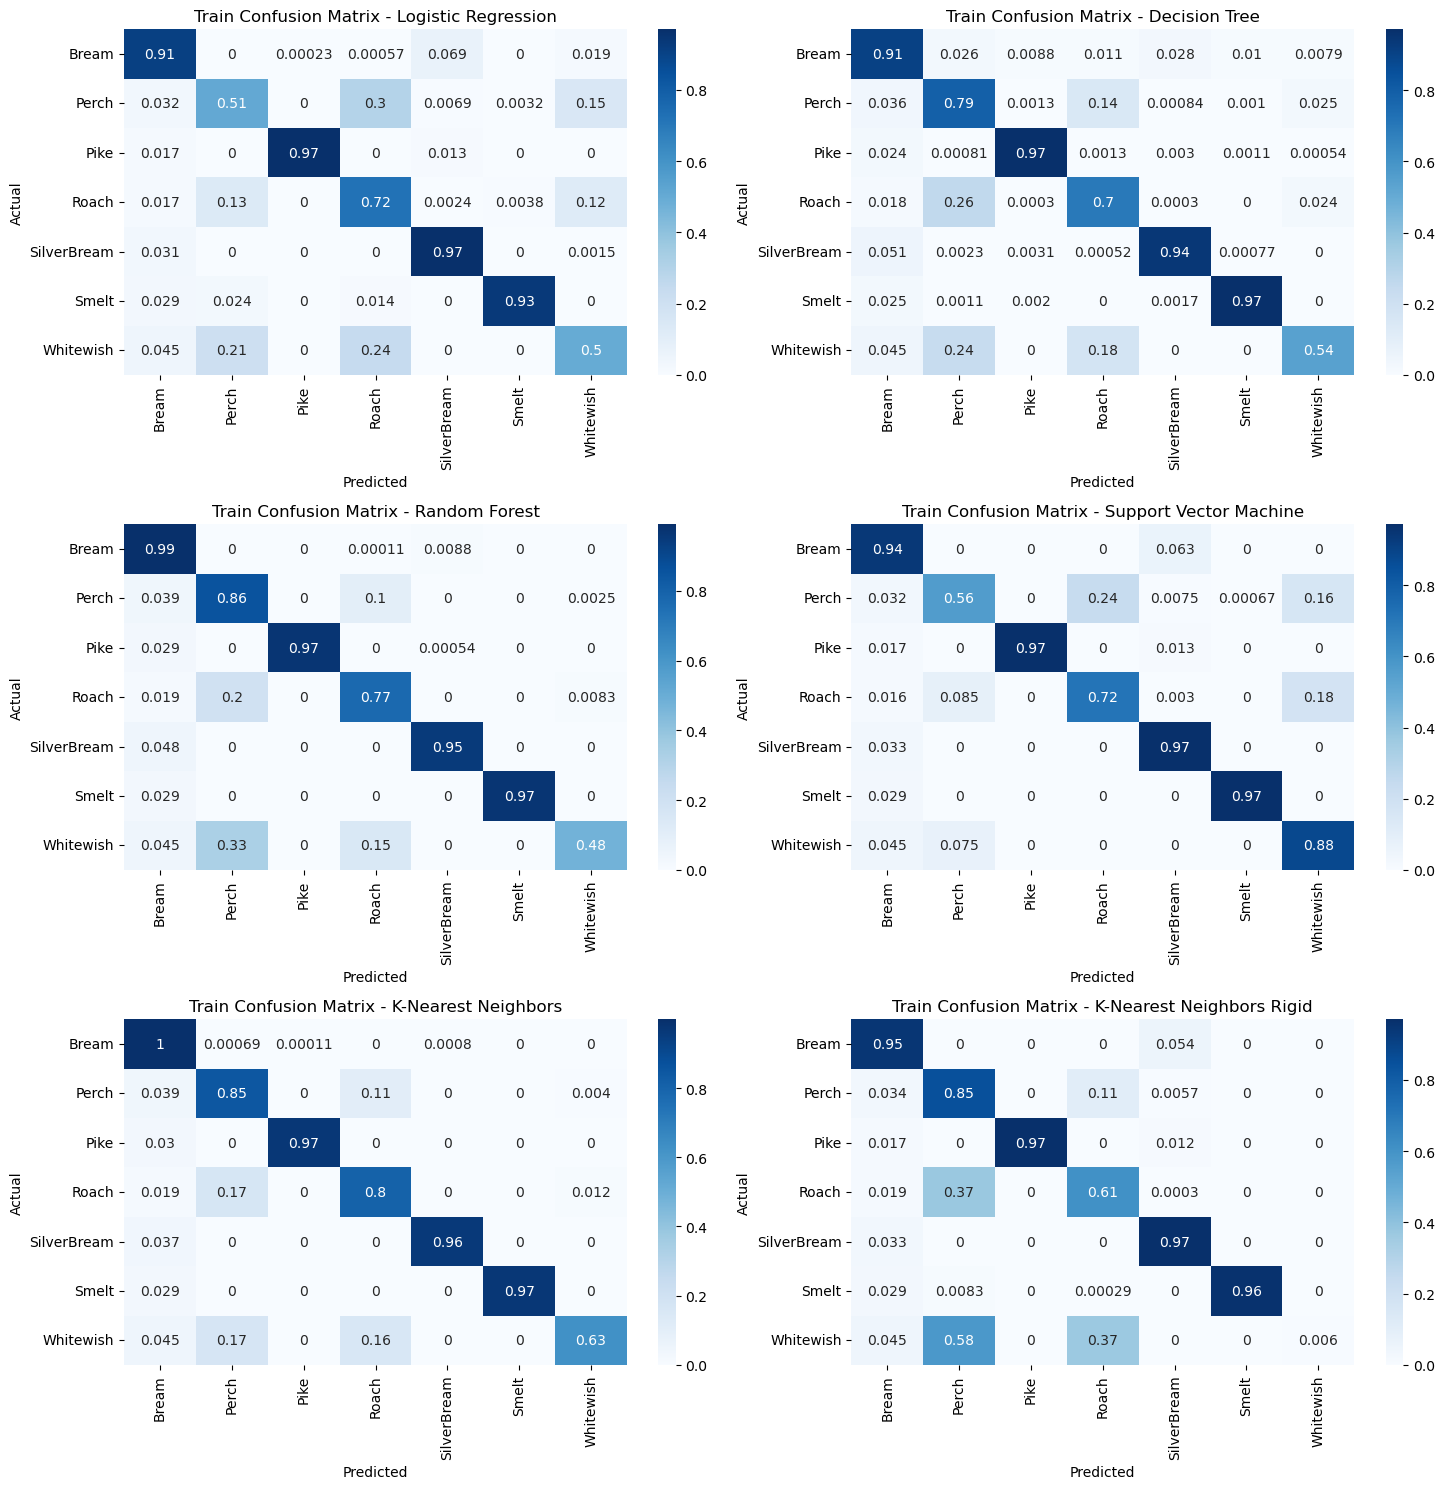

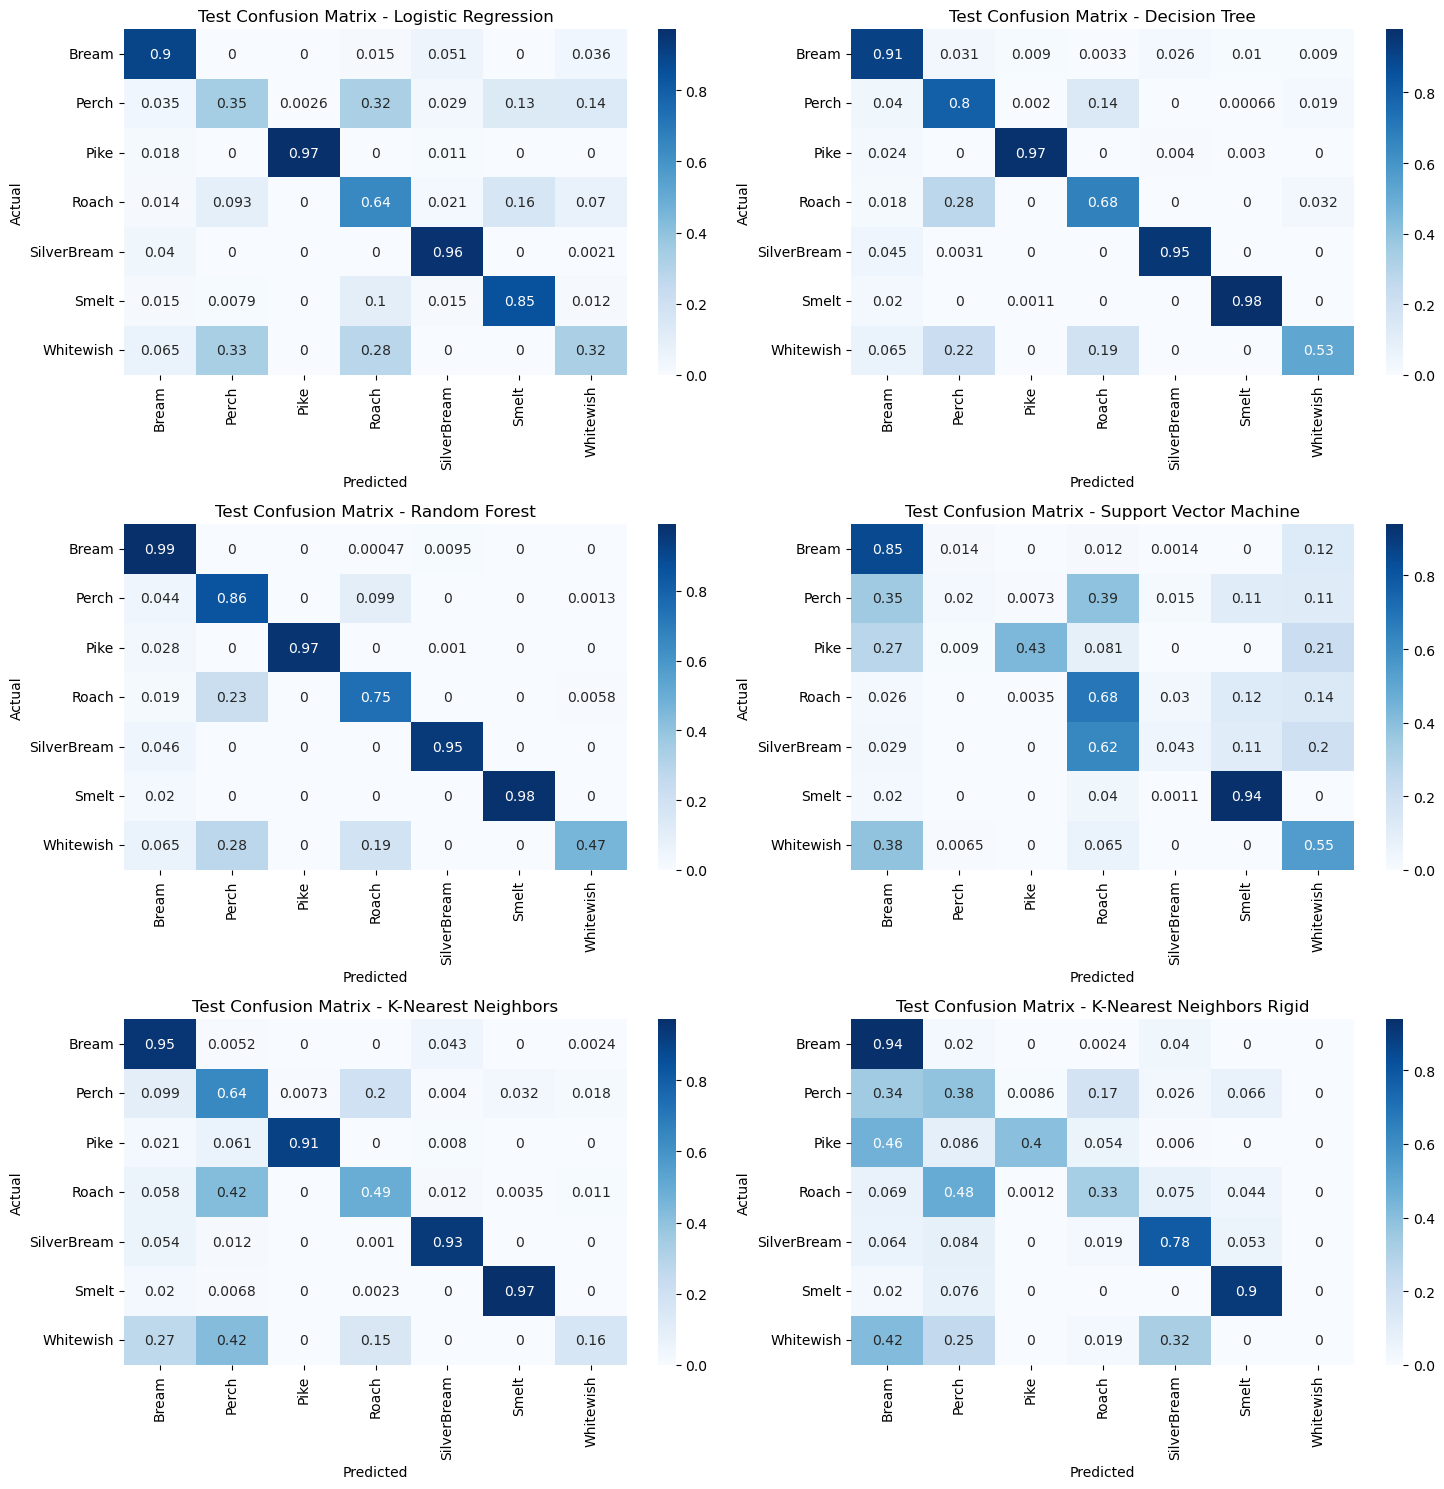

In [282]:
plot_confusion_matricies(all_conf_matrix_train, all_conf_matrix_test, y_test)

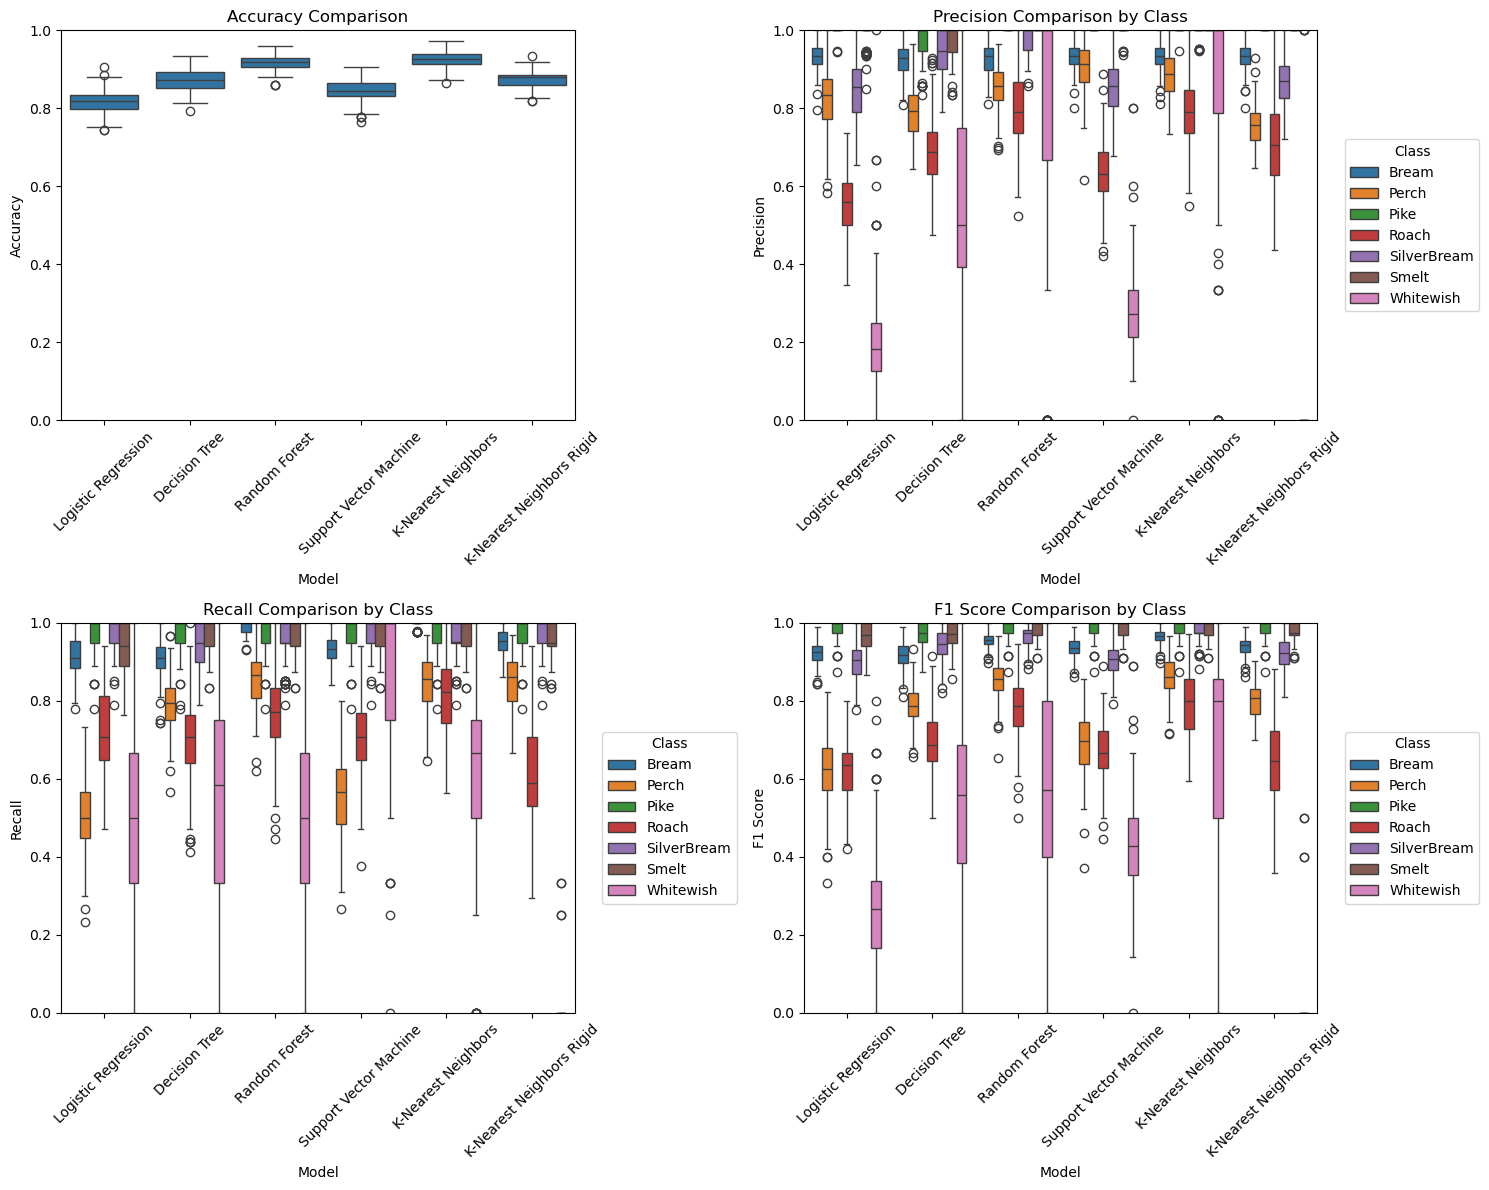

In [262]:
plot_boxplots(results_train, y)

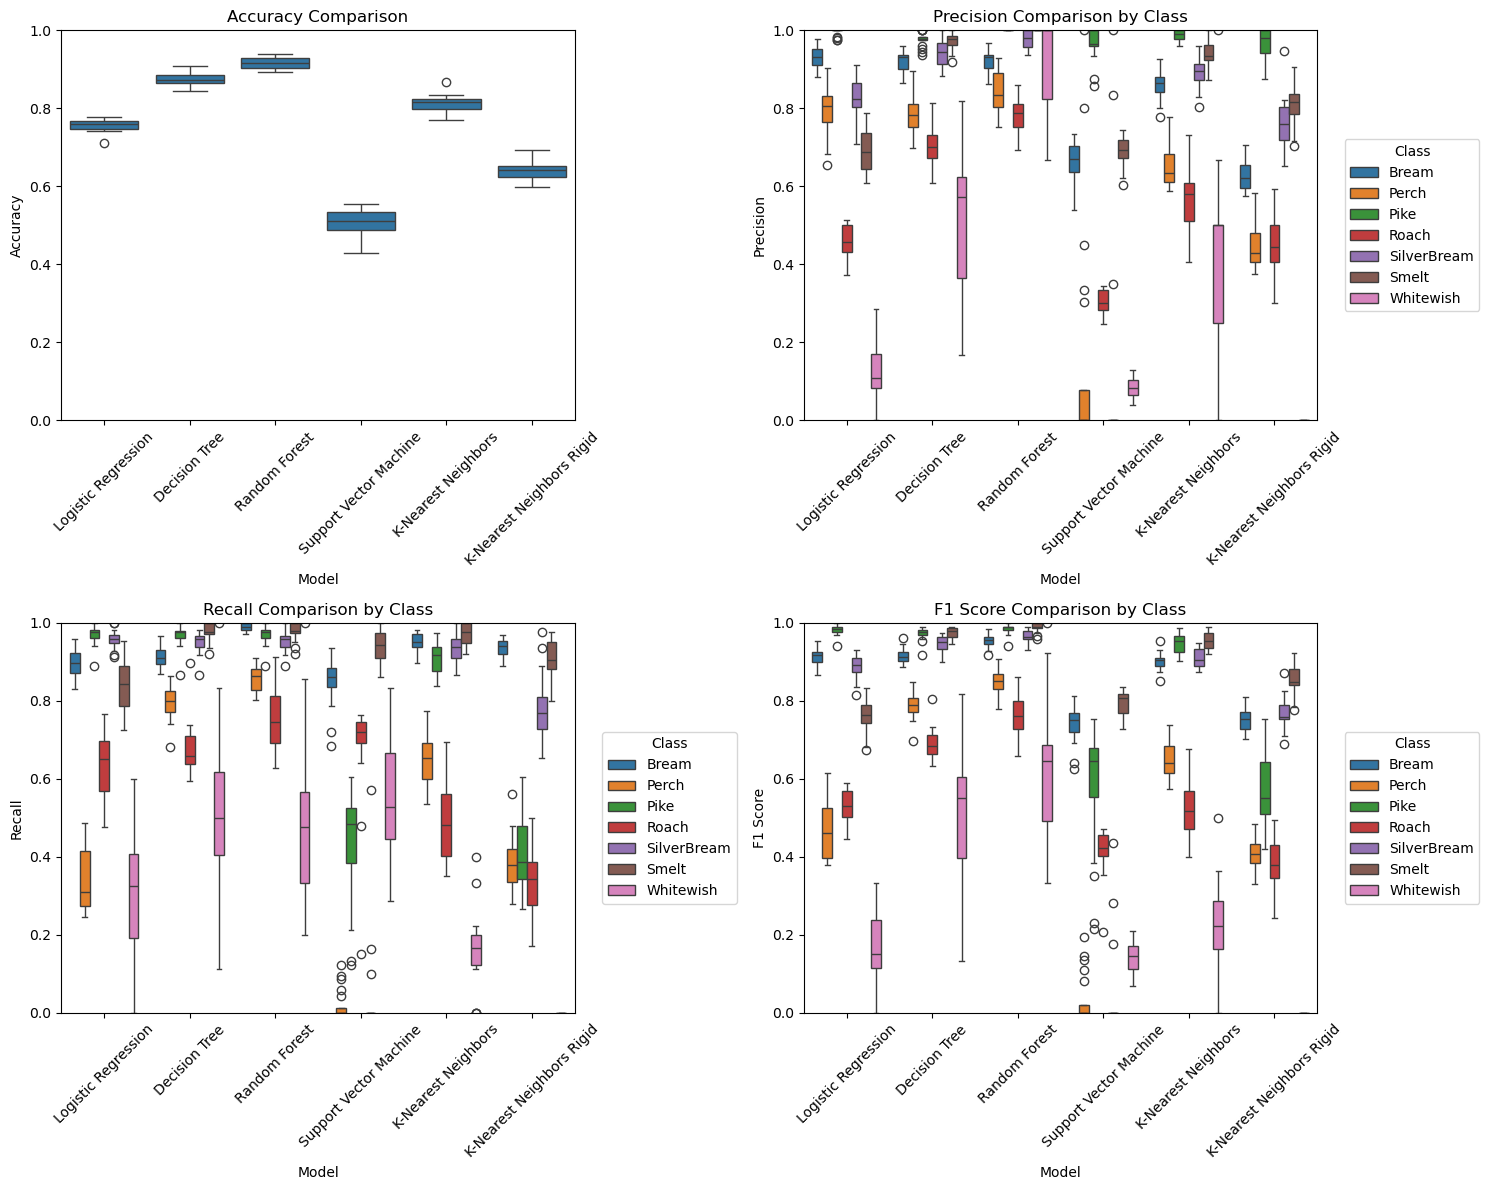

In [263]:
plot_boxplots(results_test, y)

In [ ]:
all_results_train_smote = []
all_results_test_smote = []
all_conf_matrix_train_smote = {}
all_conf_matrix_test_smote = {}
for _ in range(50):
    results_train_temp_smote, results_test_temp_smote, conf_train_smote, conf_test_smote = run_train_multiple_testing(X, y, task="a", class_weight=None, average=None, do_smote=True)
    all_results_train_smote.append(results_train_temp_smote)
    all_results_test_smote.append(results_test_temp_smote)
    for key, value in conf_train_smote.items():
        if key in all_conf_matrix_train_smote:
            all_conf_matrix_train_smote[key] += value
        else:
            all_conf_matrix_train_smote[key] = value
            
    for key, value in conf_test_smote.items():
        if key in all_conf_matrix_test_smote:
            all_conf_matrix_test_smote[key] += value
        else:
            all_conf_matrix_test_smote[key] = value
    

results_train_smote = all_results_train_smote[0]
results_test_smote = all_results_test_smote[0]

for i in range(1, len(all_results_train_smote)):
    results_train_smote = merge_dictionaries(results_train_smote, all_results_train_smote[i])
    results_test_smote = merge_dictionaries(results_test_smote, all_results_test_smote[i])

for key, value in all_conf_matrix_train_smote.items():
    all_conf_matrix_train_smote[key] = value / value.sum(axis=1)[:, np.newaxis]
    
for key, value in all_conf_matrix_test_smote.items():
    all_conf_matrix_test_smote[key] = value / value.sum(axis=1)[:, np.newaxis]


print("successfully merged")

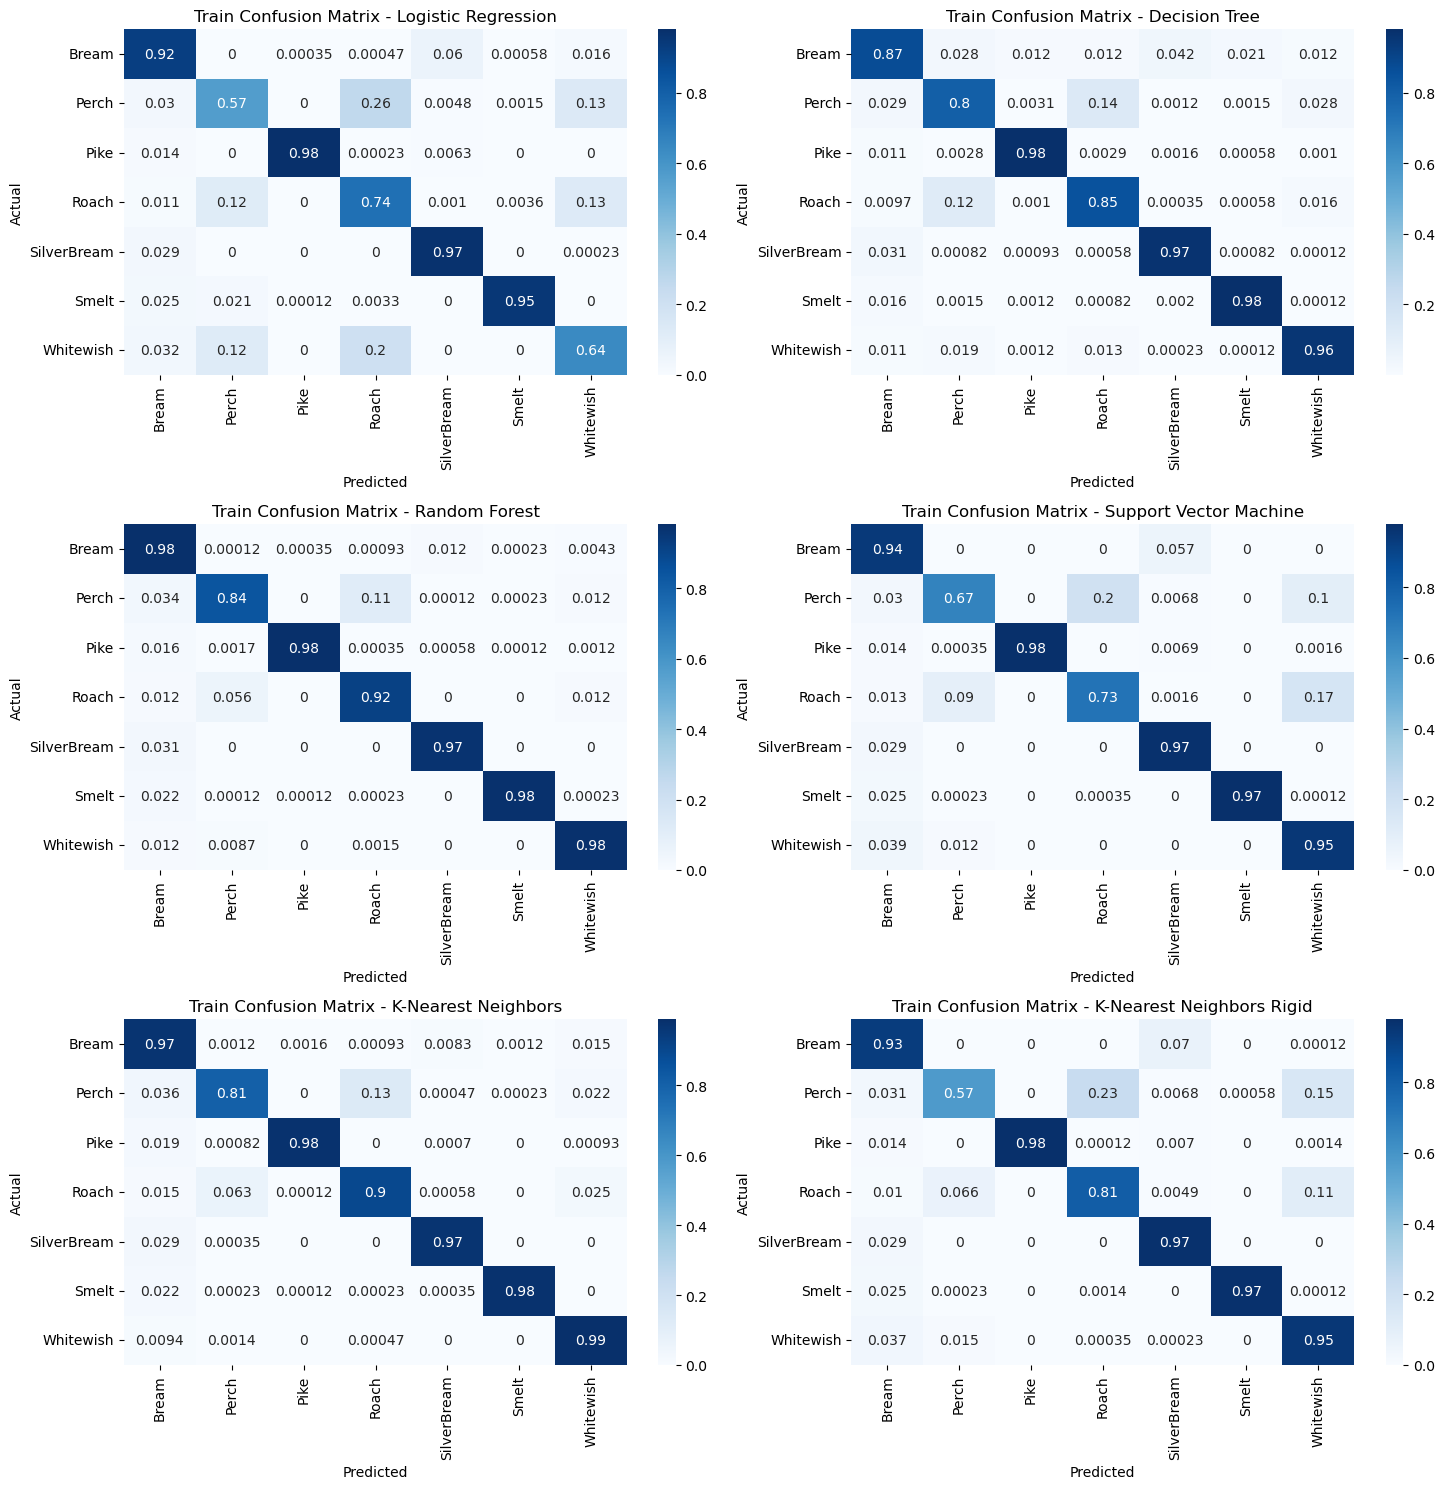

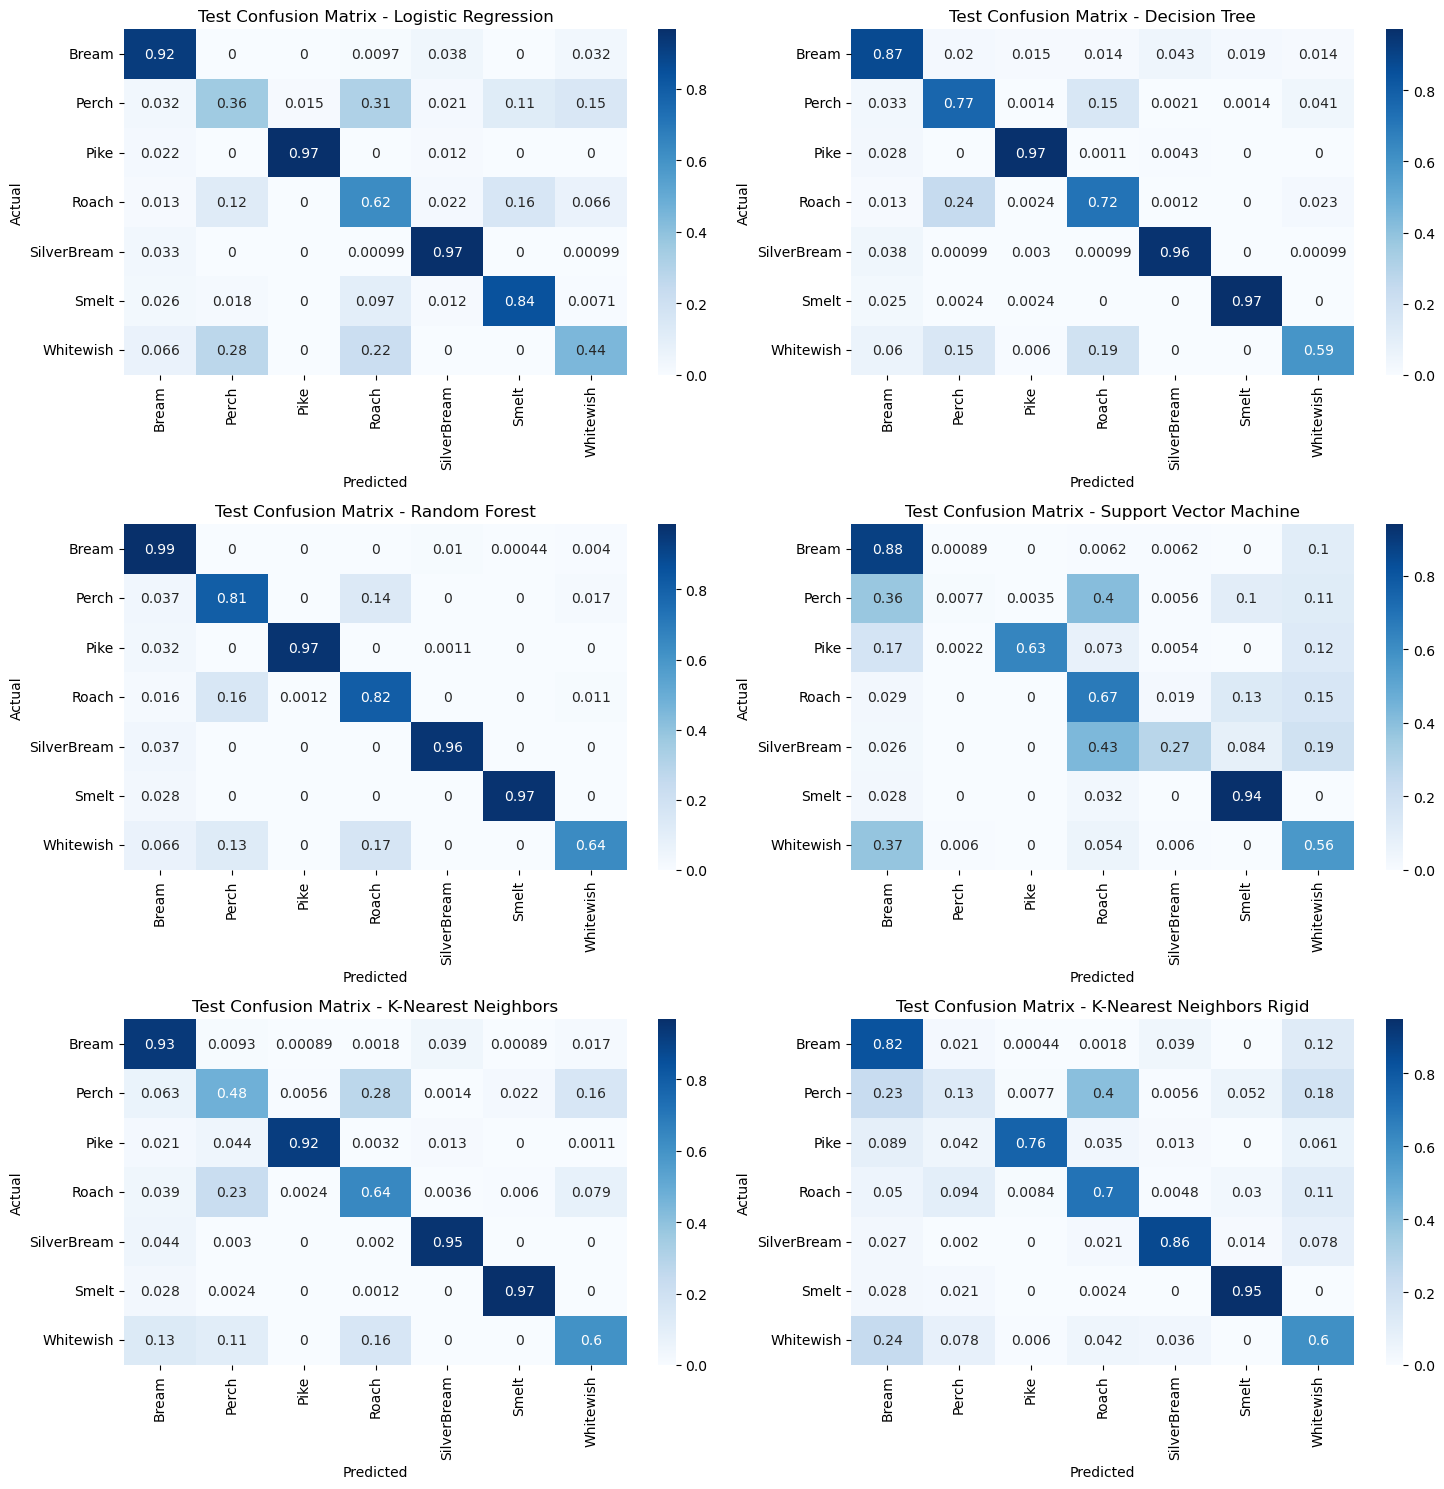

In [283]:
plot_confusion_matricies(all_conf_matrix_train_smote, all_conf_matrix_test_smote, y_test)


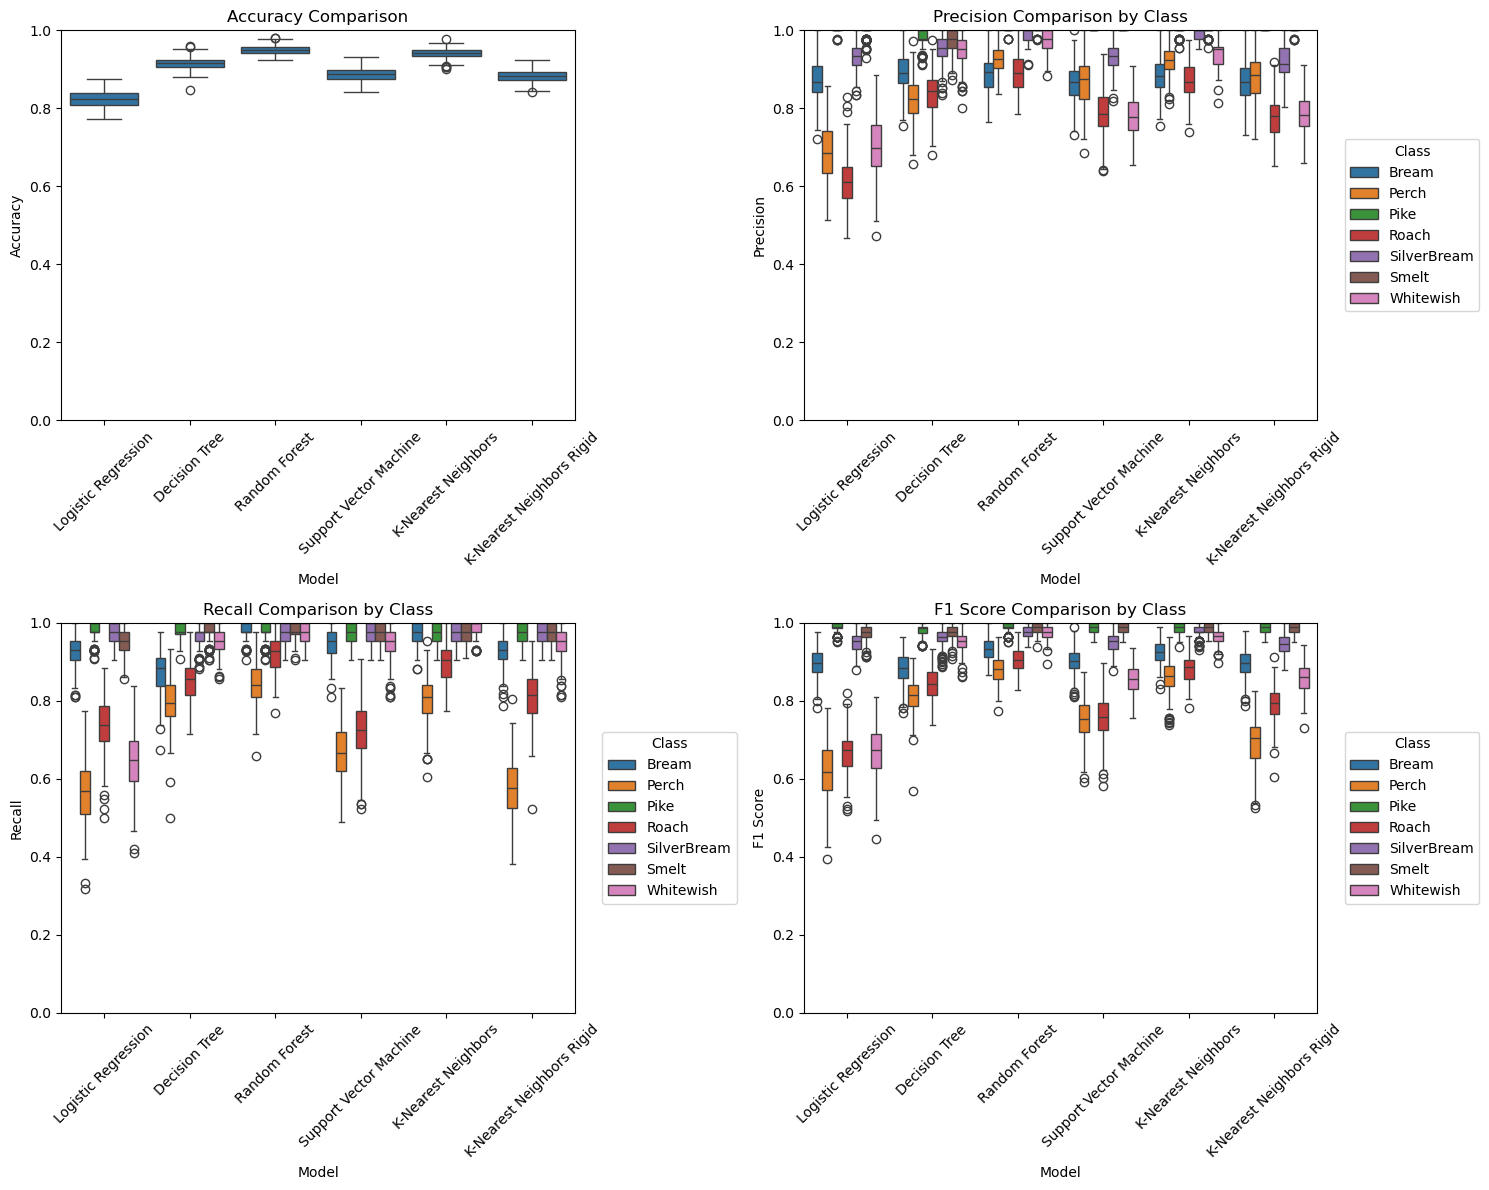

In [266]:
plot_boxplots(results_train_smote, y)

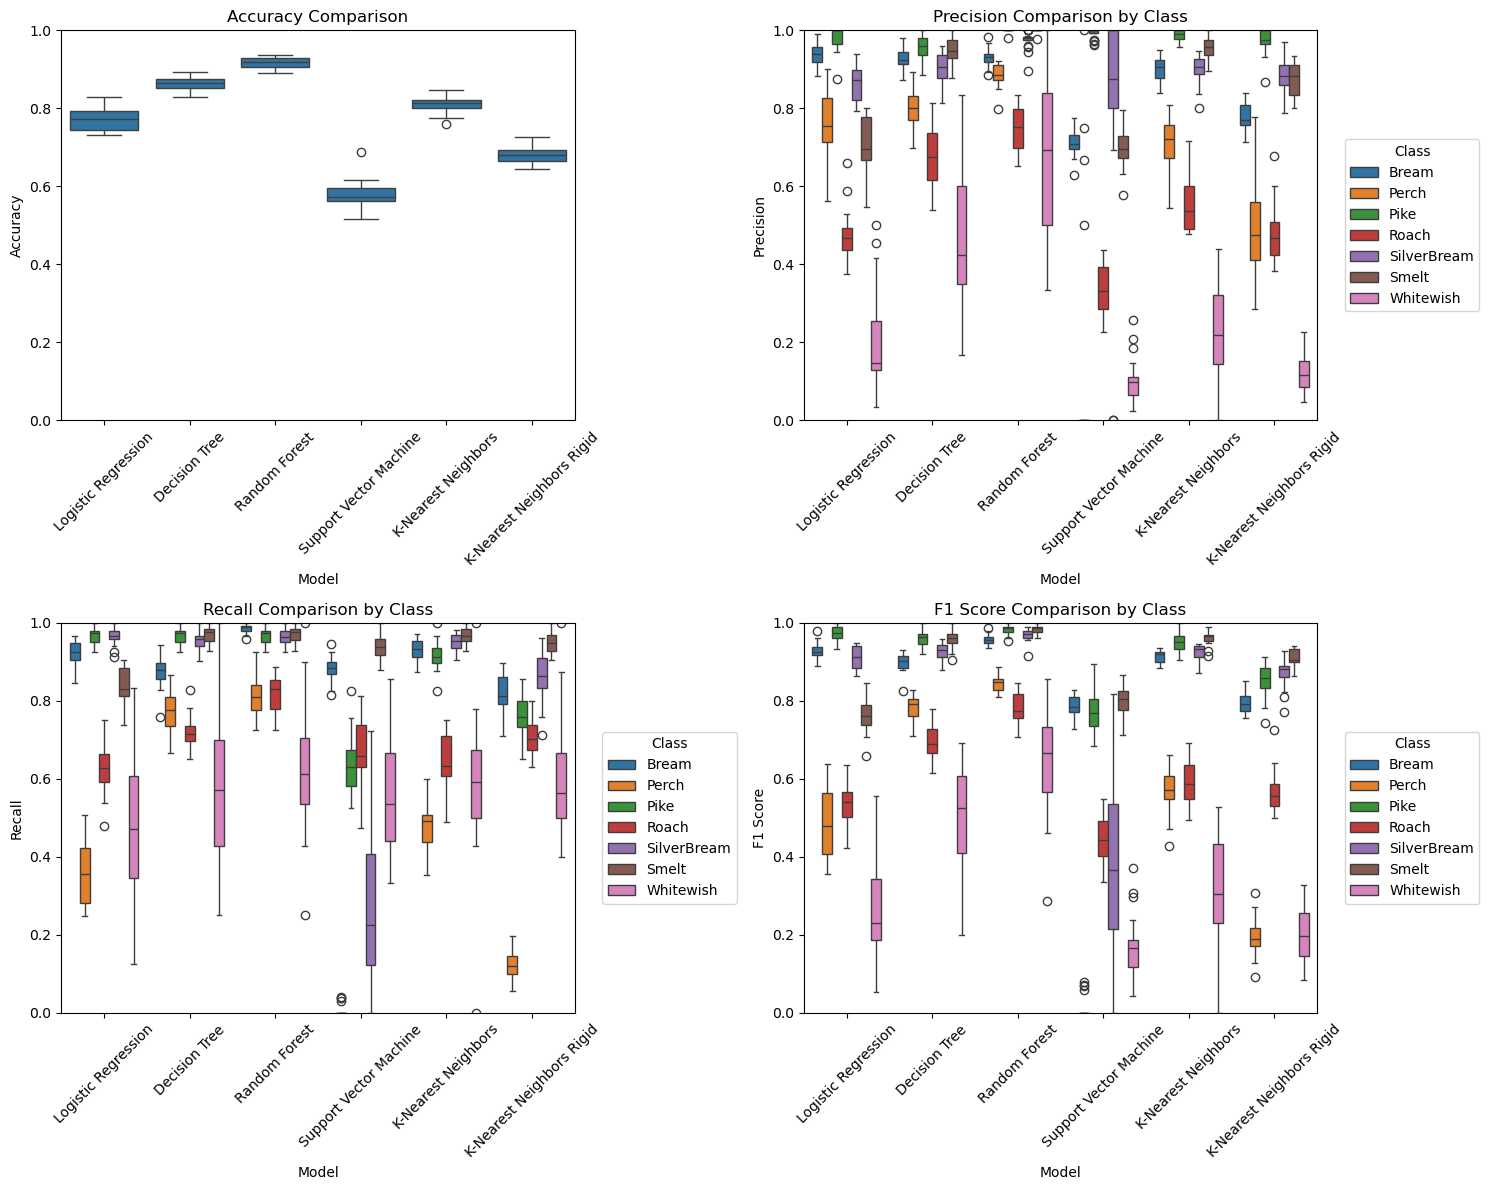

In [267]:
plot_boxplots(results_test_smote, y)

## b